In [146]:
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi

In [147]:
#parameters
Sbase = 1000
Vbase = 400/np.sqrt(3)
Ibase = Sbase/Vbase
Vbase = np.sqrt(2)*Vbase
Ibase = np.sqrt(2)*Ibase

f_base = 50
omega_base = 2*np.pi*f_base
Zbase = Vbase/Ibase
Rbase = Vbase/Ibase
Lbase = Zbase/(2*pi*50)
Cbase = 1/(Zbase*2*pi*50)
#machine parameters
X_dd = 0.296
X_d = 1.56
X_q = 2
X_qd = 0.4
T_dod = 3.7
T_qod = 0.6
D = 0.0005
J = 20
R_sg = 0.0

#excitation system paramters
T_A = 0.05
K_A = 200
V_ref = 1.15

#Governor system parameters
T_sv = 0.05
P_ref = 1
R_d = 0.05
T_ch =0.5 


##Rate load is 1 pu
R_load = 0.8
X_load = 0.6
#for infinite grid
#theta = np.arctan(X_load/R_load)

In [148]:
class Synchronous_Machine:
    def __init__(self):
        self.state = np.array([0.0,0.0,0.0,0.0])
        self.i_d = self.i_q = 0.0
        self.I = np.array([self.i_d,self.i_q])
        self.change_state(self.state)
        self.E_fd = 0.0
        self.T_m = 0.0
        self.change_input(self.E_fd,self.T_m,self.I)

    def change_input(self, E_fd, T_m, I):
        self.E_fd = E_fd
        self.T_m = T_m
        self.i_d, self.i_q = I
    
    def change_state(self,x):
        self.d_omega = x[0]
        self.delta =x[1]
        self.E_qd = x[2]
        self.E_dd = x[3]
        
        self.V_d = self.E_dd - R_sg* + self.i_q*X_qd
        self.V_q = self.E_qd - self.i_d*X_dd - self.i_q*R_sg

        self.output = np.array([self.V_d,self.V_q])
        self.state = np.array([self.d_omega,self.delta, self.E_qd, self.E_dd])

    def derivative(self, E_fd,T_m,I):
        self.change_input(E_fd,T_m,I)

        P_ei = self.E_dd*self.i_d + self.E_qd*self.i_q - (X_dd-X_qd)*self.i_d * self.i_q
        T_ei = P_ei
        d_omega_dot = (1/(J)) *(self.T_m - T_ei + D*(self.d_omega))
        delta_dot = self.d_omega
        E_qd_dot = (1/T_dod) *(-self.E_qd - (X_d - X_dd)*self.i_d + self.E_fd)
        E_dd_dot = (1/T_qod) *(-self.E_dd + (X_q - X_qd)*self.i_q)

        return np.array([d_omega_dot,delta_dot,E_qd_dot,E_dd_dot])

In [149]:
class Governor:
    def __init__(self):
        self.state = np.array([0.0,0.0])
        self.change_state(self.state)
        self.P_ref = 0.0
        self.d_omega = 0.0
        self.change_input(self.P_ref,self.d_omega)
    
    def change_input(self,P_ref,d_omega):
        self.P_ref = P_ref
        self.d_omega = d_omega

    def change_state(self,x):
        self.P_sv = x[0]
        self.T_m = x[1]

        self.output = self.T_m
        self.state = np.array([self.P_sv,self.T_m])

    def derivative(self,P_ref,d_omega):
        self.change_input(P_ref,d_omega)
        P_sv_dot = (1/T_sv)*(-self.P_sv + self.P_ref - (1/(R_d)*self.d_omega))
        T_m_dot = (1/T_ch)*(-self.T_m + self.P_sv)
        return np.array([P_sv_dot, T_m_dot])


In [150]:
class Exciter:
    def __init__(self):
        self.state = 0.0
        self.change_state(self.state)
        self.V_ref = 0.0
        self.V_t = 0.0
        self.change_input(self.V_ref,self.V_t)

    def change_input(self,V_ref, V_t):
        self.V_ref = V_ref
        self.V_t = V_t

    def change_state(self,x):
        self.E_fd = x

        self.output = self.E_fd
        self.state = self.E_fd
    
    def derivative(self,V_ref,V_t):
        self.change_input(V_ref,V_t)
        E_fd_dot = (1/T_A)*(-self.E_fd + K_A*(self.V_ref- self.V_t))
        return E_fd_dot

In [151]:
class Load:
    def __init__(self):
        self.R_load = R_load
        self.X_load = X_load
        self.change_input(0.0,0.0)
    
    def change_input(self, V_d, V_q):
        self.V_d = V_d
        self.V_q = V_q
        I_cmpx = complex(self.V_d,self.V_q)/complex(self.R_load,self.X_load)
        self.I_d = np.real(I_cmpx)
        self.I_q = np.imag(I_cmpx)
        self.I = np.array([self.I_d, self.I_q])
        self.output = self.I

In [152]:
ts = np.linspace(0, 20, 100000)
dt = ts[1]
V_ref = 1
P_ref = 1

In [153]:
def Machine_in_Grid(Machine,Governor, Exciter,Load):
    Delta = np.zeros(len(ts))
    D_Omega = np.zeros(len(ts))
    Load_V_d = np.zeros(len(ts))
    Load_V_q = np.zeros(len(ts))
    Load_I_d = np.zeros(len(ts))
    Load_I_q = np.zeros(len(ts))
    for i,t in enumerate(ts):
        #change state here
        Machine.change_state(Machine.state + Machine.derivative(Exciter.output,Governor.output, Load.output)*dt)
        V_d, V_q = Machine.V_d, Machine.V_q
        V_t = np.sqrt(V_d**2 + V_q**2)
        d_omega = Machine.d_omega
        Exciter.change_state(Exciter.state + Exciter.derivative(V_ref, V_t)*dt)
        Governor.change_state(Governor.state + Governor.derivative(P_ref,d_omega)*dt)
        Load.change_input(V_d,V_q) 
        #Load.change_input(1*np.cos(theta), 1*np.sin(theta)) #for infinte grid
        #collect output here
        D_Omega[i] = Machine.d_omega
        Delta[i] = Machine.delta
        Load_V_d[i] = Load.V_d
        Load_V_q[i] = Load.V_q
        Load_I_d[i] = Load.I_d
        Load_I_q[i] = Load.I_q

    return [D_Omega,Delta, Load_V_d,Load_V_q, Load_I_d,Load_I_q]
        

In [154]:
machine = Synchronous_Machine()
exciter = Exciter()
governor = Governor()
load = Load()

In [155]:
d_omega,delta, V_d, V_q, I_d,I_q = Machine_in_Grid(machine,governor,exciter,load)

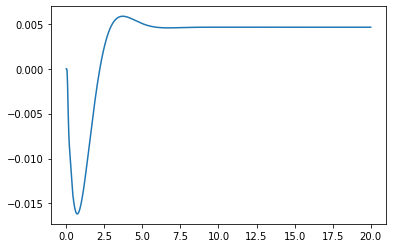

In [156]:
plt.plot(ts,d_omega)

In [158]:
V_t = np.sqrt(V_d**2 + V_q**2)
I_l = np.sqrt(I_d**2 , I_q**2)

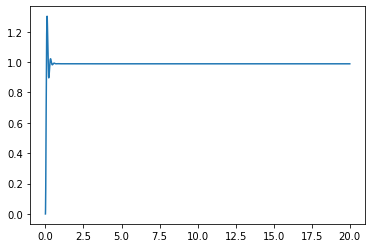

In [159]:
plt.plot(ts,V_t)

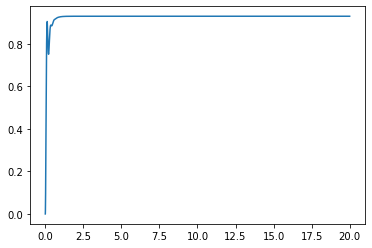

In [160]:
plt.plot(ts,I_l)